In [1]:
## DeepExplain - Keras (TF backend) example
### MNIST with CNN

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tempfile, sys, os
sys.path.insert(0, os.path.abspath('..'))

import keras
from keras.datasets import mnist
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras import regularizers
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import numpy as np
import tensorflow as tf
import scipy

# Import DeepExplain
from deepexplain.tensorflow import DeepExplain

#Import DeepLift
import deeplift
from deeplift.layers import NonlinearMxtsMode
from deeplift.conversion import kerasapi_conversion as kc
from deeplift.util import compile_func


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# Build and train a network.

SKIP_TRAIN = False
saved_model_file = 'model.h5'

batch_size = 128
num_classes = 10
epochs = 10

# input image dimensions
img_rows, img_cols = 4, 4

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = np.array([scipy.misc.imresize(x, (img_rows,img_cols,)) for x in x_train])
x_test = np.array([scipy.misc.imresize(x, (img_rows,img_cols,)) for x in x_test])



#x_train = x_train.reshape(-1, 28,28,1)
#x_test = x_test.reshape(-1, 28,28,1)
x_train = x_train.reshape(-1, img_rows*img_cols)
x_test = x_test.reshape(-1, img_rows*img_cols)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
x_train = (x_train - 0.5) * 2
x_test = (x_test - 0.5) * 2
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

#with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context

def f(x):
    return x*tf.sigmoid(x)

if SKIP_TRAIN:
    model = load_model(saved_model_file)
else:
    #de.enable_override('shapley')
    model = Sequential()
    #model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(28,28,1)))
    #model.add(Conv2D(64, (3, 3), activation='relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.25))
    #model.add(Flatten())
    model.add(Dense(64, input_shape=(img_rows*img_cols,), activation='relu', kernel_regularizer=regularizers.l1(0.000)))
    model.add(Dense(48, activation='relu', kernel_regularizer=regularizers.l1(0.000)))       
    model.add(Dense(num_classes, kernel_regularizer=regularizers.l1(0.00)))
    model.add(Activation('softmax'))
    # ^ IMPORTANT: notice that the final softmax must be in its own layer 
    # if we want to target pre-softmax units

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))
    model.save(saved_model_file)
    print (model.layers[0].get_weights()[0].mean())
    print (model.layers[0].get_weights()[0].var())
    
#score = model.evaluate(x_test, y_test, verbose=0)
#print('Test loss:', score[0])
#print('Test accuracy:', score[1])

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:16: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


x_train shape: (60000, 9)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 39us/step - loss: 1.8157 - acc: 0.3659 - val_loss: 1.4910 - val_acc: 0.4753
Epoch 2/10
60000/60000 [==============================] - 1s 25us/step - loss: 1.3172 - acc: 0.5516 - val_loss: 1.1629 - val_acc: 0.6252
Epoch 3/10
60000/60000 [==============================] - 1s 23us/step - loss: 1.1458 - acc: 0.6153 - val_loss: 1.0591 - val_acc: 0.6442
Epoch 4/10
60000/60000 [==============================] - 2s 26us/step - loss: 1.0549 - acc: 0.6472 - val_loss: 0.9747 - val_acc: 0.6685
Epoch 5/10
60000/60000 [==============================] - 2s 31us/step - loss: 0.9900 - acc: 0.6701 - val_loss: 0.9200 - val_acc: 0.6853
Epoch 6/10
60000/60000 [==============================] - 2s 28us/step - loss: 0.9359 - acc: 0.6871 - val_loss: 0.8985 - val_acc: 0.6899
Epoch 7/10
60000/60000 [==============================] - 2s 31

(array([2.82581e+05, 1.01000e+04, 1.02540e+04, 1.04560e+04, 1.06340e+04,
        1.07040e+04, 1.14620e+04, 1.19940e+04, 1.23830e+04, 1.30270e+04,
        1.33300e+04, 1.32300e+04, 1.34840e+04, 1.29990e+04, 1.22340e+04,
        1.15370e+04, 1.12250e+04, 1.04340e+04, 9.84900e+03, 9.45400e+03,
        8.92900e+03, 8.78600e+03, 8.34200e+03, 8.01100e+03, 7.70800e+03,
        7.49700e+03, 7.12000e+03, 6.90800e+03, 6.61700e+03, 6.31600e+03,
        5.96300e+03, 5.53000e+03, 5.39300e+03, 5.06300e+03, 4.73800e+03,
        4.43300e+03, 4.14900e+03, 3.68000e+03, 3.26300e+03, 3.01600e+03,
        2.73000e+03, 2.17700e+03, 1.76400e+03, 1.45300e+03, 1.27100e+03,
        9.71000e+02, 8.43000e+02, 7.15000e+02, 6.56000e+02, 5.69000e+02,
        5.33000e+02, 4.95000e+02, 4.33000e+02, 4.07000e+02, 3.71000e+02,
        2.70000e+02, 2.28000e+02, 1.61000e+02, 1.15000e+02, 1.00000e+02,
        6.00000e+01, 7.30000e+01, 6.90000e+01, 6.10000e+01, 5.70000e+01,
        5.40000e+01, 4.00000e+01, 4.20000e+01, 3.70

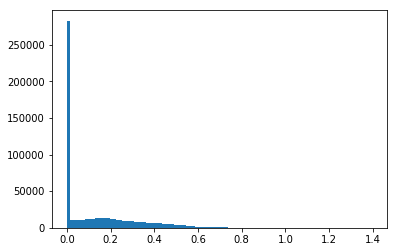

In [4]:
%matplotlib inline
aModel = Model(inputs=model.inputs, outputs=[model.layers[1].input])
y = aModel.predict(x_test)
import matplotlib.pyplot as plt
#plt.hist(model.layers[1].get_weights()[0].flatten(), 100)
plt.hist(y.flatten(), 100)

In [5]:
# Define what to be explained
xs = x_test[1:2]
ys = y_test[1:2]

In [6]:
# Compute DeepLift attributions
revealcancel_model = kc.convert_model_from_saved_files(
                            h5_file=saved_model_file,
                            nonlinear_mxts_mode=NonlinearMxtsMode.RevealCancel)
rescale_model = kc.convert_model_from_saved_files(
                            h5_file=saved_model_file,
                            nonlinear_mxts_mode=NonlinearMxtsMode.Rescale)

revealcancel_func = revealcancel_model.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-2)
rescale_func = rescale_model.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-2)

a_rc = np.array(revealcancel_func(
                task_idx=np.argmax(ys),
                input_data_list=[xs],
                input_references_list=[np.zeros_like(xs)],
                batch_size=100,
                progress_update=None))

a_res = np.array(rescale_func(
                task_idx=np.argmax(ys),
                input_data_list=[xs],
                input_references_list=[np.zeros_like(xs)],
                batch_size=100,
                progress_update=None))


nonlinear_mxts_mode is set to: RevealCancel
Heads-up: I assume softmax is the output layer, not an intermediate one; if it's an intermediate layer, please let me know and I will prioritise that use-case
nonlinear_mxts_mode is set to: Rescale
Heads-up: I assume softmax is the output layer, not an intermediate one; if it's an intermediate layer, please let me know and I will prioritise that use-case


In [7]:
%time
with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context
    # Need to reconstruct the graph in DeepExplain context, using the same weights.
    # With Keras this is very easy:
    # 1. Get the input tensor to the original model
    input_tensor = model.layers[0].input
    
    # 2. We now target the output of the last dense layer (pre-softmax)
    # To do so, create a new model sharing the same layers untill the last dense (index -2)
    fModel = Model(inputs=input_tensor, outputs = model.layers[-2].output)
    target_tensor = fModel(input_tensor)
    

    
    a_gradin = de.explain('grad*input', target_tensor * ys, input_tensor, xs)
    #attributions = de.explain('saliency', target_tensor * ys, input_tensor, xs)
    a_intgrad = de.explain('intgrad', target_tensor * ys, input_tensor, xs)
    #attributions2 = de.explain('deeplift', target_tensor * ys, input_tensor, xs)
    a_linear = de.explain('linear', target_tensor * ys, input_tensor, xs)
    a_shap = de.explain('shapley', target_tensor * ys, input_tensor, xs)
    #a_shap = np.zeros_like(a_linear)
    
    #attributions2 = de.explain('elrp', target_tensor * ys, input_tensor, xs)
    #attributions = de.explain('occlusion', target_tensor * ys, input_tensor, xs)
    print ("Done")

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.48 µs
{'Elu': 'DeepExplainGrad', 'Relu': 'DeepExplainGrad', 'Softplus': 'DeepExplainGrad', 'Sigmoid': 'DeepExplainGrad', 'MatMul': 'MatMulDeepExplainGrad', 'Tanh': 'DeepExplainGrad'}
DeepExplain: running "grad*input" explanation method (2)
Model with multiple inputs:  False
DeepExplain: running "intgrad" explanation method (3)
Model with multiple inputs:  False
DeepExplain: running "linear" explanation method (7)
Model with multiple inputs:  False
DeepExplain: running "shapley" explanation method (6)
Model with multiple inputs:  False
Shapley: computing references...
model_2/dense_3/MatMul_w (48, 10)
model_2/dense_3/MatMul_b (10,)
model_2/dense_2/MatMul_w (64, 48)
model_2/dense_2/MatMul_x (1, 64)
model_2/dense_1/MatMul_x (1, 9)
model_2/dense_3/MatMul_x (1, 48)
model_2/dense_1/MatMul_w (9, 64)
model_2/dense_2/MatMul_b (48,)
model_2/dense_1/MatMul_b (64,)
Shapley: references ready
(1, 48)
(48, 10)
(10,)
(1, 48)
Skip dense_3
(1, 64

In [8]:
# Compute exacly shapley values!

from deepexplain.tensorflow.exact_shapley import compute_shapley
a_exact = compute_shapley(xs[0], lambda x: (fModel.predict(np.array([x]))*ys).sum())
#a_exact = np.zeros_like(a_gradin)

/usr/local/lib/python3.5/dist-packages/matplotlib/colors.py:823: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:2784: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)


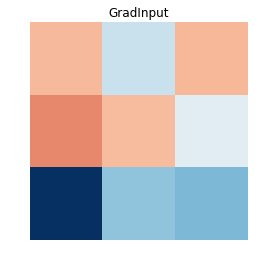

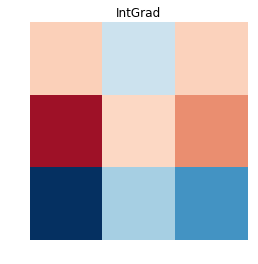

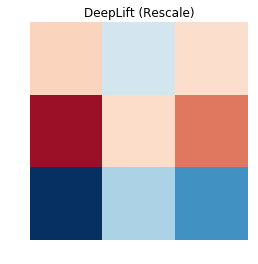

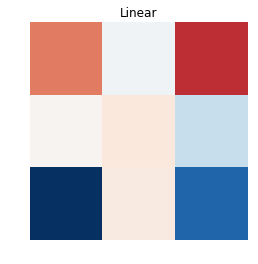

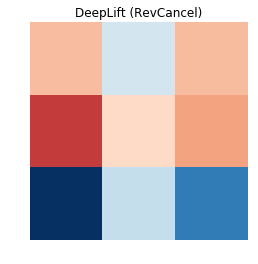

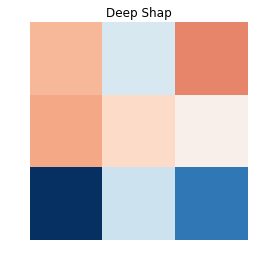

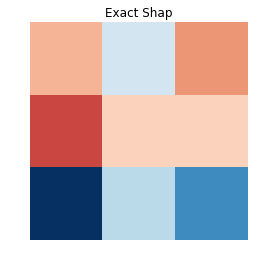

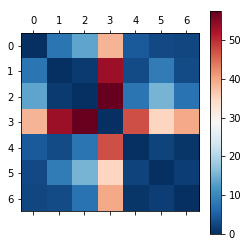

In [9]:
# Plot attributions
from utils import plot, plt
%matplotlib inline
plot(a_gradin.reshape(img_rows, img_cols), xs.reshape(img_rows, img_cols)).title('GradInput')
plt.figure()
plot(a_intgrad.reshape(img_rows, img_cols), xs.reshape(img_rows, img_cols)).title('IntGrad')
plt.figure()
plot(a_res.reshape(img_rows, img_cols), xs.reshape(img_rows, img_cols)).title('DeepLift (Rescale)')
plt.figure()
plot((a_linear).reshape(img_rows, img_cols), xs.reshape(img_rows, img_cols)).title('Linear')
plt.figure()
plot(a_rc.reshape(img_rows, img_cols), xs.reshape(img_rows, img_cols)).title('DeepLift (RevCancel)')
plt.figure()
plot((a_shap).reshape(img_rows, img_cols), xs.reshape(img_rows, img_cols)).title('Deep Shap')
plt.figure()
plot((a_exact).reshape(img_rows, img_cols), xs.reshape(img_rows, img_cols)).title('Exact Shap')

methods = [a_gradin, a_intgrad, a_res,a_linear, a_rc, a_shap, a_exact]
confusion = np.zeros((len(methods), len(methods)))
for i, m1 in enumerate(methods):
    for j, m2 in enumerate(methods):
        confusion[i][j] = ((m1-m2)**2).mean()
plt.figure()
plt.matshow(confusion, cmap='RdBu_r')
plt.colorbar()
        
        


In [10]:
from deepexplain.tensorflow.accuracy_robustness import run_robustness_test
original_maps = [a_gradin, a_intgrad, a_res, a_linear, a_rc, a_shap, a_exact]
names = ['GradInput', 'IntGrad', 'DeepLift (Recale)','Linear', 'DeepLift (RevCanc)', 'ApprShapley', 'Shapley']
run_robustness_test(fModel, xs, ys, original_maps, names, 'Test', 1,
                        result_path='.', mode='prediction', reduce_dim=None)



Running robustness test...
Storing robustness results...
Done


In [11]:
from deepexplain.tensorflow.sensitivityn import run_sensitivity_test
run_sensitivity_test(fModel, xs, ys, original_maps, names, 'Test',
                        result_path='.', number_of_samples=1000)


Running delta test...
Done





In [12]:
model.save('model.h5')